In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import koreanize_matplotlib
import seaborn as sns
from scipy import stats

import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, StandardScaler
import shap

import warnings

In [44]:
from sklearn.metrics import make_scorer

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

scores = make_scorer(evaluate_regr)

In [4]:
warnings.filterwarnings('ignore')
# 노트북 안에 그래프를 그리기 위해
%matplotlib inline
plt.style.use('ggplot') # 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
mpl.rcParams['axes.unicode_minus'] = False # 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처

RANDOM_STATE = 110
pd.set_option('display.max_columns', None)

train_df = pd.read_csv("../../data/bike/train.csv", parse_dates=['datetime'])
test_df = pd.read_csv("../../data/bike/test.csv", parse_dates=['datetime'])
santander_submission_df = pd.read_csv("../../data/bike/sampleSubmission.csv")

> - 2011년 1월 ~ 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안 자전거 대여 횟수 데이터가 있다.

> - datetime: hourly date + timestamp
> - season: 1 - 봄, 2 - 여름, 3- 가을, 4 - 겨울
> - holyday: 1 - 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 - 휴일이 아닌 날
> - workingday: 1 - 토, 일요일의 주말 및 휴일이 아닌 주중, 0 - 주말 및 휴일
> - weather:
> - - 1 = 맑음, 약간 구름 낀 흐림 / 2 = 안개, 안개 + 흐림 / 3 = 가벼운 눈, 가벼운 비 + 천둥 / 4 = 심한 눈/비, 천둥/번개
> - temp: 온도(섭씨)
> - atemp: 체감 온도(섭씨)
> - humidity: 상대 습도
> - windspeed: 풍속
> - casual: 사전에 등록되지 않은 사용자가 대여한 횟수
> - registered: 사전에 등록된 사용자가 대여한 횟수
> - count: 대여 횟수

## Feature Engineering

In [5]:
train_df['year'] = train_df.datetime.apply(lambda x: x.year)
train_df['month'] = train_df.datetime.apply(lambda x: x.month)
train_df['day'] = train_df.datetime.apply(lambda x: x.day)
train_df['hour'] = train_df.datetime.apply(lambda x: x.hour)
train_df["dayofweek"] = train_df["datetime"].dt.dayofweek

test_df['year'] = test_df.datetime.apply(lambda x: x.year)
test_df['month'] = test_df.datetime.apply(lambda x: x.month)
test_df['day'] = test_df.datetime.apply(lambda x: x.day)
test_df['hour'] = test_df.datetime.apply(lambda x: x.hour)
test_df["dayofweek"] = test_df["datetime"].dt.dayofweek

train_df.drop(['datetime'], axis=1, inplace=True)

In [6]:
print(train_df.shape)
print(test_df.shape)

(10886, 17)
(6493, 14)


> - 풍속 데이터를 시각화를 하면 0에 굉장히 많은 값이 모여있는 것을 확인할 수 있다.
> - 따라서 풍속의 0 값에 특정 값을 넣어줘야 한다.
> - 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 되지 않을 수도 있다.

> - 풍속이 0인 것과 아닌 것의 세트를 나누어 예측을 통해 풍속을 구하는 방법

<Axes: xlabel='windspeed', ylabel='count'>

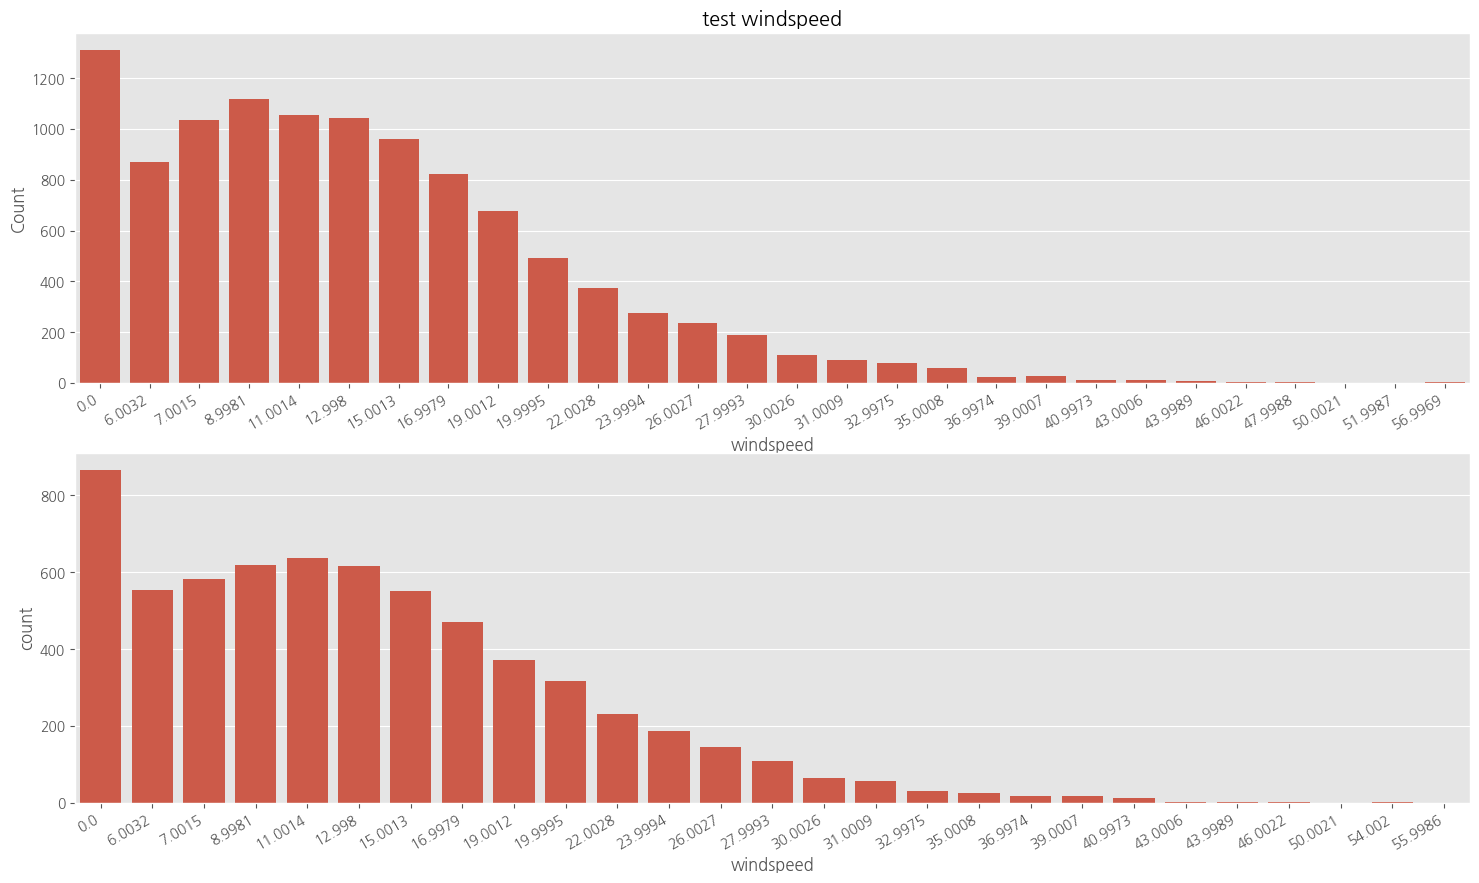

In [10]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18, 10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title="train windspeed")
sns.countplot(data=train_df, x='windspeed', ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title="test windspeed")
sns.countplot(data=test_df, x='windspeed', ax=axes[1])

In [12]:
trainWind0 = train_df.loc[train_df['windspeed'] == 0]
trainWind1 = train_df.loc[train_df['windspeed'] != 0]

In [17]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWind1 = data.loc[data['windspeed'] != 0]

    # 풍속을 예측할 feature
    wcol = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWind1['windspeed'] = dataWind1['windspeed'].astype('str')

    rf = RandomForestClassifier()
    rf.fit(dataWind1[wcol], dataWind1["windspeed"])
    windvalues = rf.predict(dataWind0[wcol])

    predictWind0 = dataWind0
    predictWind1 = dataWind1

    # 값이 0으로 기록된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0['windspeed'] = windvalues
    # 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = pd.concat([predictWind1, predictWind0])

    data['windspeed'] = data['windspeed'].astype('float')

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data

<Axes: title={'center': 'train_df windspeed'}, xlabel='windspeed', ylabel='Count'>

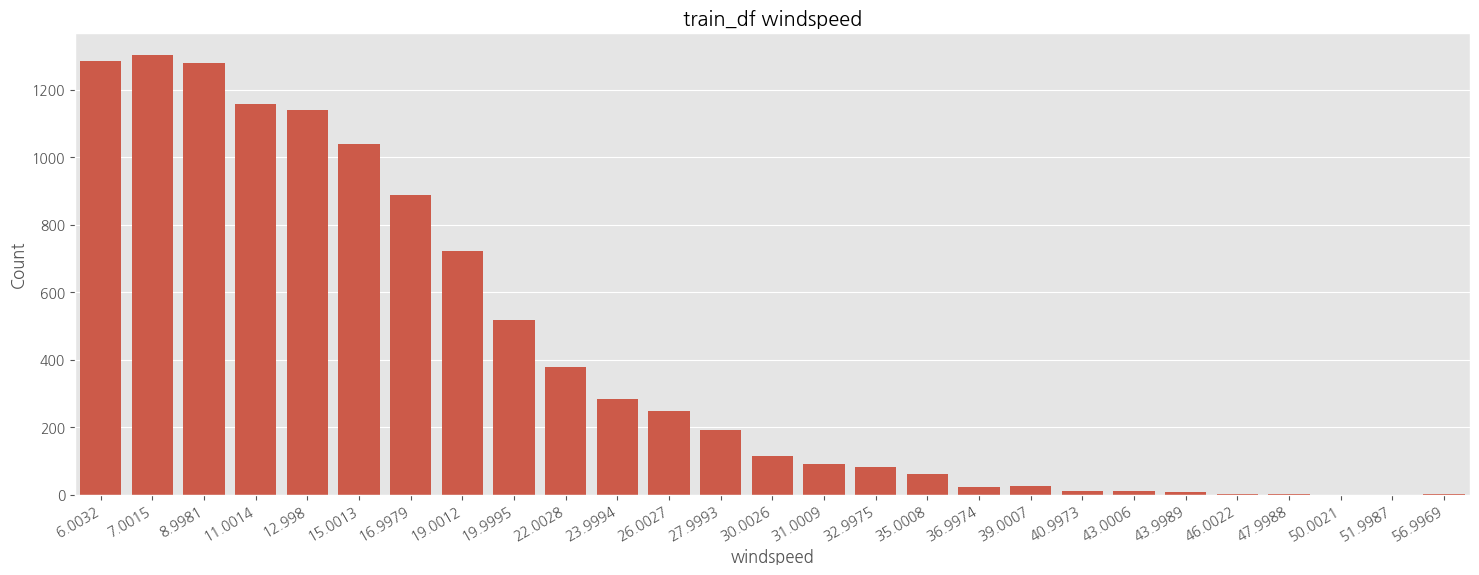

In [18]:
train_df = predict_windspeed(train_df)

fig, axl = plt.subplots()
fig.set_size_inches(18, 6)

plt.sca(axl)
plt.xticks(rotation=30, ha='right')
axl.set(ylabel='Count', title='train_df windspeed')
sns.countplot(data=train_df, x="windspeed", ax=axl)

## Feature Selection
> - 신호와 잡음을 구분해야 한다.
> - 피처가 많다고 무조건 좋은 성능을 내지 않는다.
> - 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [48]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,1,5,5
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12,24,36,2011,1,1,10,5
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26,30,56,2011,1,1,11,5
3,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,29,55,84,2011,1,1,12,5
4,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,47,47,94,2011,1,1,13,5


In [47]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,3


In [20]:
categorical_feature = ['season', 'holiday', 'workingday', 'weather', 'dayofweek', 'month', 'year', 'hour']

for i in categorical_feature:
    train_df[i] = train_df[i].astype('category')
    test_df[i] = test_df[i].astype('category')

In [ ]:
# 연속형 feature = ['temp', 'humidity', 'windspeed', 'atemp']

In [21]:
train_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'dayofweek'],
      dtype='object')

In [24]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [25]:
X_train = train_df[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [26]:
X_test = test_df[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [31]:
label_name = "count"

y_train = train_df[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

In [ ]:
stop

# randomforest

In [27]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [28]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
model

RandomForestRegressor(n_jobs=-1, random_state=0)

In [45]:
%time
score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=scores)
score = score.mean()

# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

CPU times: user 4 μs, sys: 3 μs, total: 7 μs
Wall time: 24.8 μs
RMSLE: 0.317, RMSE: 43.563, MAE: 26.623
RMSLE: 0.339, RMSE: 40.125, MAE: 25.503
RMSLE: 0.330, RMSE: 40.827, MAE: 24.437
RMSLE: 0.320, RMSE: 41.529, MAE: 26.245
RMSLE: 0.324, RMSE: 43.596, MAE: 25.836
RMSLE: 0.341, RMSE: 39.847, MAE: 24.838
RMSLE: 0.338, RMSE: 43.250, MAE: 26.015
RMSLE: 0.318, RMSE: 41.823, MAE: 25.628
RMSLE: 0.348, RMSE: 44.183, MAE: 26.087
RMSLE: 0.331, RMSE: 42.607, MAE: 25.364
Score= nan


In [35]:
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [36]:
# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.61,   5.05,   4.35,   3.44,   3.05,   6.25,  38.21, 106.2 ,
       235.8 , 136.57])

[Text(0.5, 1.0, 'test')]

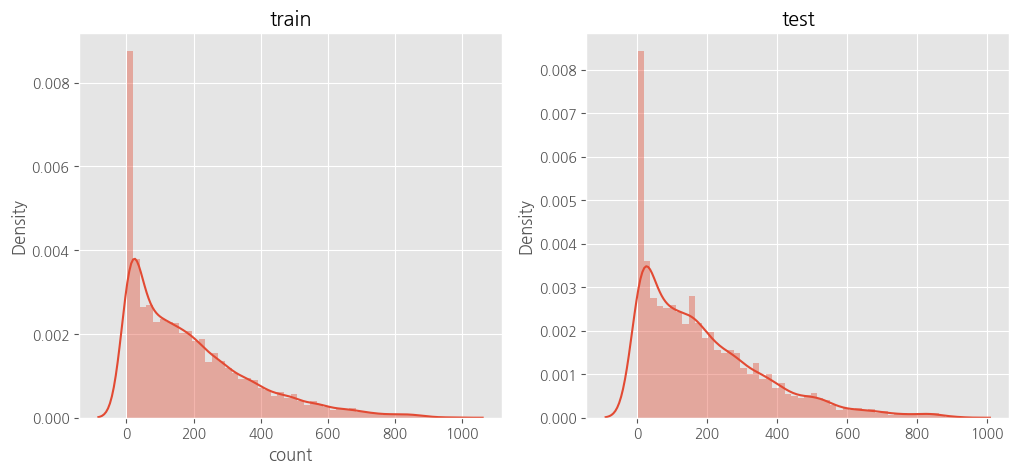

In [37]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

In [39]:
submission = pd.read_csv("../../data/bike/sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.61
1,2011-01-20 01:00:00,5.05
2,2011-01-20 02:00:00,4.35
3,2011-01-20 03:00:00,3.44
4,2011-01-20 04:00:00,3.05


In [41]:
submission.to_csv("submission.csv".format(score), index=False)

In [43]:
438/3243

0.13506012950971322

### 선형회귀 모델 Linear Regression Model
> - 선형회귀 또는 최소제곱법은 가장 간단하고 오래된 회귀용 선형 알고리즘
> - 선형회귀는 예측과 훈련 세트에 있는 타깃 y사이의 평균제곱오차(MSE)를 최소화하는 파라미터 w와 b를 찾는다.
> - 매개변수가 없는 것이 장점이지만, 모델의 복잡도를 제어할 수 없다는 단점이 있다.

In [55]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

lr = LinearRegression()
y_target_log = np.log1p(y_train)
lr.fit(X_train, y_target_log)

preds = lr.predict(X_train)
print(rmsle(np.exp(y_target_log), np.exp(preds)))

0.9798440336450596


### 릿지 Regularization Model - Ridge
> - 회귀를 위한 선형모델
> - 가중치(w)의 모든 원소가 0에 가깝게 만들어 모든 피처가 주는 영향을 최소화(기울기를 작게 만듦)
> - Regularization(정규화)는 오버피팅(과대적합)이 되지 않도록 모델을 강제로 제한한다는 의미
> - max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

In [57]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_, ridge_params_, scoring = rmsle_scorer, cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds)))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9798440316312492


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005452,0.003007,0.004861,0.002514,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-0.264788,-0.204260,-0.249533,-0.202784,-0.239989,-0.232271,0.024775,1
1,0.004734,0.002807,0.000941,0.000197,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-0.264789,-0.204260,-0.249533,-0.202783,-0.239989,-0.232271,0.024776,2
2,0.002887,0.002381,0.002082,0.001321,1,3000,"{'alpha': 1, 'max_iter': 3000}",-0.264799,-0.204263,-0.249532,-0.202776,-0.239987,-0.232272,0.024779,3
3,0.001681,0.000214,0.001209,0.000948,2,3000,"{'alpha': 2, 'max_iter': 3000}",-0.264811,-0.204266,-0.249531,-0.202769,-0.239986,-0.232272,0.024783,4
4,0.002625,0.002247,0.001782,0.000970,3,3000,"{'alpha': 3, 'max_iter': 3000}",-0.264822,-0.204269,-0.249530,-0.202761,-0.239984,-0.232273,0.024787,5


In [58]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.232271
1,0.10,0.232271
2,1.00,0.232272
3,2.00,0.232272
4,3.00,0.232273


### 라쏘 Regularization Model - Lasso
> - 선형회귀의 Regularization(규제)를 적용하는 대안
> - 계수를 0에 가깝게 만들려고 하며 이를 L1규제라고 하며, 어떤 계수는 0이 되기도 하는데 이는 완전히 제외하는 피처가 생긴다는 의미다.
> - 피처 선택이 자동으로 이루어진다고도 볼 수 있다.
> - alpha 값의 기본 값은 1.0이며, 과소 적합을 줄이기 위해서는 이 값을 줄여야 한다.
> - 그리드 서치로 아래 라쏘모델을 실행했을 때 베스트 알파값은 0.0025
> - max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

In [59]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds)))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)


{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9798534813907083


## randomforest

In [61]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds))
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.10643022528404658


### 앙상블모델 - 그라디언트 부스트
> - Ensemble Model - Gradient Boost
> - 여러개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
> - 회귀와 분류에 모두 사용할 수 있음
> - 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
> - 무작위성이 없고 강력한 사전 가지치기가 사용 됨
> - 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
> - learning_rate : 오차를 얼마나 강하게 보정할 것인지를 제어
> - n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가 되어 모델의 복잡도가 커지고 훈련세트에서의 실수를 바로잡을 기회가 많아지지만 너무 크면 모델이 복잡해지고 오버피팅(과대적합)이 될 수있다.
> - max_depth(max_leaf_nodes) 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.

In [63]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds))
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.20432215888359562


<Axes: ylabel='Density'>

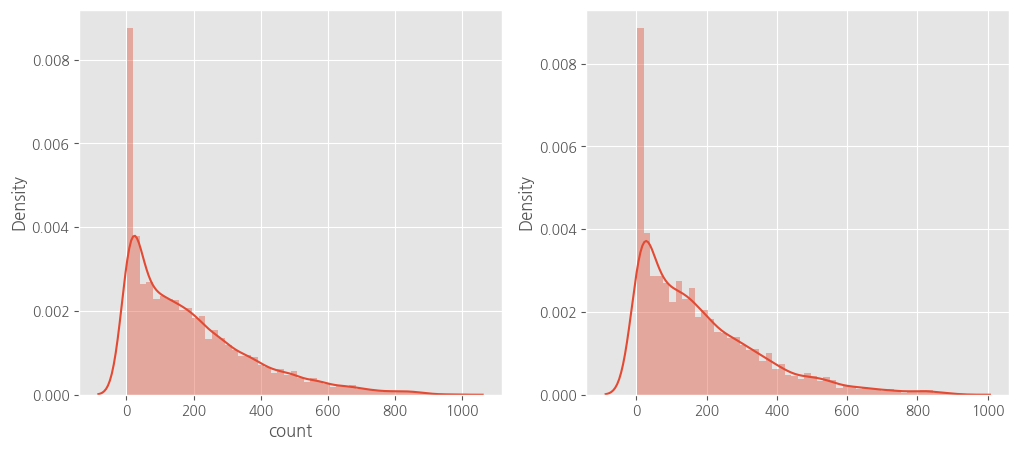

In [66]:
predsTest = rfModel.predict(X_test)

fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [67]:
submission = pd.read_csv("../../data/bike/sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,11.815647
1,2011-01-20 01:00:00,5.273176
2,2011-01-20 02:00:00,4.011278
3,2011-01-20 03:00:00,4.054901
4,2011-01-20 04:00:00,3.712711


In [68]:
submission.to_csv("submission_best.csv".format(score), index=False)

In [69]:
208/3243

0.06413814369411039